# Multi Mode Interferrometer

> Modeling an mmi using meow

In [ ]:
#| default_exp mmi_eme

In [ ]:
import warnings
from skill_challenge.util import np, gf, mw, tqdm, cachedComputeModes

2023-06-18 20:14:03.831 | INFO     | gdsfactory.config:__init__:204 - LogLevel: INFO
2023-06-18 20:14:06.543 | INFO     | gdsfactory.simulation.gtidy3d:<module>:60 - Tidy3d '2.2.2' installed at ['/opt/conda/lib/python3.9/site-packages/tidy3d']


In [ ]:
def example_extrusions(
    t_slab: float = 0.0,
    t_soi: float = 0.4,
    t_ox: float = 0.0,
):
    """ create some simple extrusion rules
    
    Args:
        t_slab: the slab thickness
        t_soi: the SOI thickness
        t_ox: the oxide layer thickness
    """
    extrusions = {
        (1, 0): [
            mw.GdsExtrusionRule(
                material=mw.silicon,
                h_min=0.0,
                h_max=0.0 + t_soi,
                mesh_order=1,
            ),
        ],
    }
    return extrusions

In [ ]:
def create_structs(l_taper:float = 10, l_center:float = 20, w_center:float = 3):
   mmi = gf.components.mmi2x2(length_taper=l_taper, 
      length_mmi=l_center, 
      width_mmi=w_center)
   extrusion_rules = example_extrusions()
   structs = mw.extrude_gds(mmi, extrusion_rules)
   clad = mw.Structure(
      material=mw.silicon_oxide,
      geometry=mw.Box(
         x_min=-20,
         x_max=20,
         y_min=-20,
         y_max=20,
         z_min=-20,
         z_max=20,
      ),
   )
   return [clad] + structs

In [ ]:
eps = 1e-10
def create_cells(
        l_taper:float = 10, 
        l_center:float = 20, 
        w_center:float = 3, 
        num_cells:float = 10
):
    structs = create_structs(l_taper, l_center, w_center)

    w_sim = 6 + 2 # to be independent of w_center
    h_sim = 2.0
    mesh = 100
    Ls = [l_taper / num_cells]*num_cells
    Ls[-1] -= eps
    Ls[0] -= eps
    Ls += [2*eps, l_center-2*eps, 2*eps] + Ls
    Ls = [eps] + Ls + [eps]

    cells = mw.create_cells(
        structures=structs,  
        mesh=mw.Mesh2d(
            x=np.linspace(-w_sim/2, w_sim/2, mesh + 1),
            y=np.linspace(-h_sim/2, h_sim/2, mesh + 1),
        ),
        Ls=Ls,z_min=-l_taper
    )

    return cells

In [ ]:
def create_css(
        l_taper:float = 10, 
        l_center:float = 20, 
        w_center:float = 3, 
        num_cells:float = 10,
        wl:float = 1.55
):
    
    env = mw.Environment(wl=wl, T=25.0)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cells = create_cells(l_taper, l_center, w_center, num_cells)
        css = [mw.CrossSection(cell=cell, env=env) for cell in cells]
    
    return css

css = create_css()
mw.visualize(css[0])
mw.visualize(css[-1])

NameError: name 'mw' is not defined

In [ ]:
num_modes=8
modes = mw.compute_modes(css[0], num_modes=num_modes)
#import matplotlib.pyplot as plt
#mw.visualize(modes[0]-modes[1])
#mw.visualize(modes[0]+modes[1])

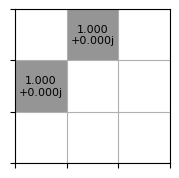

In [ ]:
S, port_map = mw.compute_interface_s_matrix(modes[:1], modes[:2])
mw.vis(S)

In [ ]:
from typing import List
from meow import Mode

def separate_supermodes(modes: List[Mode]):
    return [modes[0]+modes[1], modes[0]-modes[1]]

def separate_supermodes_io(modes: List[List[Mode]]):
    modes[0]  = separate_supermodes(modes[0])
    modes[-1] = separate_supermodes(modes[-1])
    return modes

In [ ]:
def compute_taper(
    l_taper:float = 10, 
    num_cells:float = 10,
    wl:float = 1.55,
):
    css = create_css(
        l_taper=l_taper, num_cells=num_cells, wl=wl
    )
    css = css[:num_cells+3]

    taper_modes = [mw.compute_modes(cs, num_modes=num_modes) for cs in tqdm(css)]
    #taper_modes[0] = separate_supermodes(taper_modes[0])
    S, port_map = mw.compute_s_matrix(taper_modes)
    return S, port_map, taper_modes

S, port_map, modes = compute_taper(num_cells=10)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
def compute_all_modes(
        l_taper:float = 10, 
        l_center:float = 20, 
        w_center:float = 3, 
        num_cells:float = 10,
        wl:float = 1.55,
        progress:bool = False,
):
    
    css = create_css(
        l_taper, l_center, w_center, num_cells, wl
    )

    if progress:
        css = tqdm(css, leave=False)
        
    modes = [cachedComputeModes(cs, num_modes=num_modes) for cs in css]
    return modes

super_modes = compute_all_modes()
modes = separate_supermodes_io(super_modes)

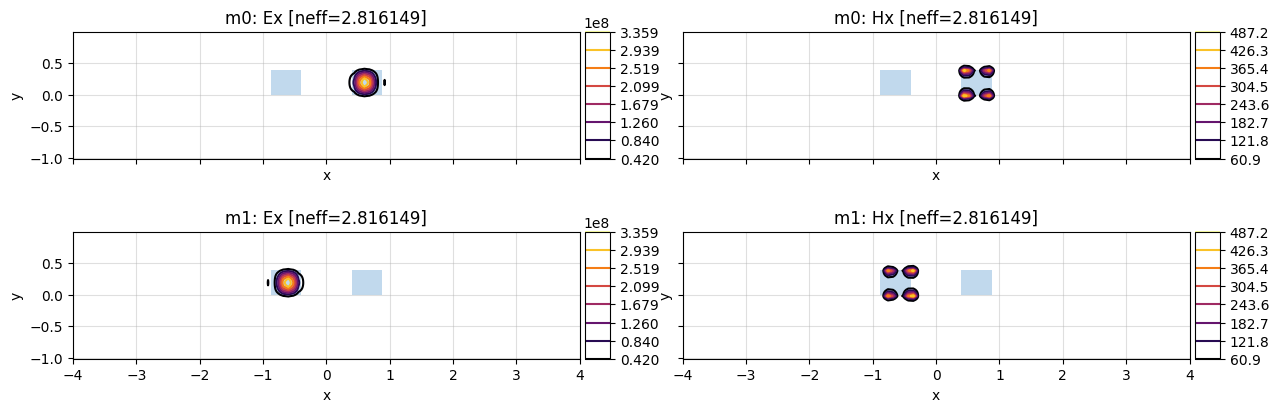

In [ ]:
mw.visualize(modes[0])

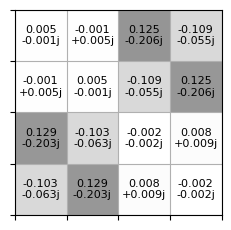

In [ ]:
def calculate_scattering(
        l_taper:float = 10, 
        l_center:float = 20, 
        w_center:float = 3, 
        num_cells:float = 10,
        wl:float = 1.55
):  
    super_modes = compute_all_modes(
        l_taper, 
        l_center, 
        w_center, 
        num_cells,
        wl
    )
    modes = separate_supermodes_io(super_modes)
    S, port_map = mw.compute_s_matrix(modes)
    return S
S = calculate_scattering()
mw.vis(S)

In [ ]:
def loss_fn(S:np.ndarray):
    trans = np.abs(S[2,0])**2
    return trans, 1/2-trans

def loss_fn2(S:np.ndarray):
    trans = np.abs(S[3,0])**2
    return trans, 1/2-trans

## TODO:
find out why imported cachedComputeModes fails...

In [ ]:
from skill_challenge.util import cCrossSection
from functools import lru_cache
@lru_cache(maxsize=None)
def inner(ccs: cCrossSection, num_modes: int):
  return mw.compute_modes(ccs.cs, num_modes)

In [ ]:
def cachedComputeModes(cs, num_modes):
  ccs = cCrossSection(cs=cs)
  try:
    modes = inner(ccs, num_modes)
  except ValueError:
    inner.cache_clear()
    modes = inner(ccs, num_modes)
  return [mode.copy(update={'cs': cs}) for mode in modes]

In [ ]:
css = create_css(w_center=3, l_center=2)
cCrossSection(cs=css[0]) == cCrossSection(cs=css[1])

True

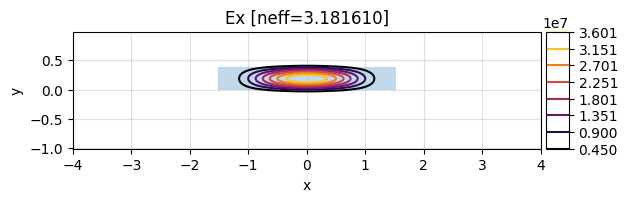

In [ ]:
for cs in create_css(w_center=3, l_center=2)[12:13]:
    mw.vis(cachedComputeModes(cs, num_modes)[0])

In [ ]:
#|eval:false
w_sweep = np.linspace(2,5,20)
l_sweep = np.linspace(10,40,50)
Ts = np.zeros((len(w_sweep), len(l_sweep), 2))
import xarray as xr

for i, w in enumerate(tqdm(w_sweep)):
    for j, l in enumerate(tqdm(l_sweep, leave=False)):
        try:
            S = calculate_scattering(w_center=w, l_center=l)
            T,_ = loss_fn(S)
            T2, _ = loss_fn2(S)
            Ts[i, j, 0] = T
            Ts[i, j, 1] = T2
        except ValueError:
            print(w, l)
            Ts[i, j] = np.nan
    ts = xr.DataArray(Ts, dims=("w", "l", "d"), coords={"w": w_sweep, "l": l_sweep, "d": ["1", "2"]})
    ts.to_netcdf('../assets/mmi.nc')

ts[:,:,0].plot()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import ray
import ray.air
import ray.air.session
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.search.hyperopt import HyperOptSearch


In [ ]:
search_config = {
    "l_center": tune.uniform(0.05, 2),
    "w_center": tune.uniform(0.05, 2),
    "l_taper": 10,
    "wl": 1.55,
    "num_cells": 10
}

tune_config = tune.TuneConfig(
    metric="loss",
    mode="min",
    search_alg=HyperOptSearch(),
    max_concurrent_trials=10,  # simulations to run in parallel
    num_samples=-1,  # max iterations, can be -1 for infinite
    time_budget_s=60
    * 20,  # time after which optimisation is stopped. May be useful along with ``num_samples=-1``.
)

In [ ]:
def trainable_simulations(config):
    """Training step, or `trainable`, function for Ray Tune to run simulations and return results."""
    
    S = calculate_scattering(**config)
    loss_x, x = loss_fn(S)
    if not np.isscalar(x):  # for many wavelengths, consider sum and mean
        loss_x, x = loss_x.sum(), x.mean()

    metrics = {"loss": loss_x, "value": x}
    checkpoint = Checkpoint.from_dict({"epoch": 1})
    session.report(metrics, checkpoint=checkpoint)

    return metrics

In [ ]:
#| eval: false
tuner = tune.Tuner(
    tune.with_resources(
        trainable_simulations, {"cpu": 1}
    ),  # maximum resources given to a worker, it also supports 'gpu'
    param_space=search_config,
    tune_config=tune_config,
    run_config=ray.air.RunConfig(
        local_dir= "ray_results",
        log_to_file=True,
        verbose=2,  # Intermediate results in Jupyter
    ),
)

# Previous simulations can be restored with, see https://docs.ray.io/en/latest/tune/tutorials/tune-stopping.html
# tuner = Tuner.restore(path=tmp / "ray_results/my_experiment")


#results = tuner.fit()
#df = results.get_dataframe()
#df

In [ ]:
import xarray as xr
def load_data(suffix):
  return xr.open_dataarray(f'../assets/mmi{suffix}.nc')

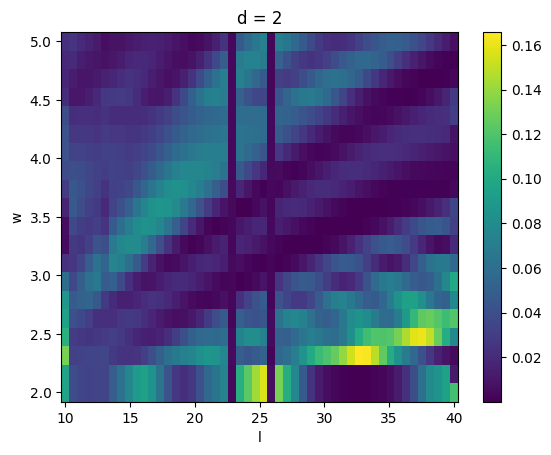

In [ ]:
data = load_data("")
data[:,:,1].plot()